# Loss Given Default

## Aim

To predict the Loss Given Default of a subprime borrower using appropriate machine learning techniques and feature engineering with relevant statistics.

## Dataset Overview

- Dataset taken from [Kaggle](https://www.kaggle.com/datasets/heydido/creditloan-dataset-rural-india)
- There is no column for LGD - it has to be derived using feature engineering.

## Import the Required Libraries and Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = pd.read_csv('../datasets/RuralCreditData.csv')

data.head()

,Id,city,age,sex,social_class,primary_business,secondary_business,annual_income,monthly_expenses,old_dependents,...,home_ownership,type_of_house,occupants_count,house_area,sanitary_availability,water_availabity,loan_purpose,loan_tenure,loan_installments,loan_amount
0,1,Dhanbad,22,F,Mochi,Tailoring,Others,36000.0,5000.0,0,...,1.0,R,4,70.0,1.0,0.5,Apparels,12,12,5000.0
1,2,Manjapra,21,F,OBC,Tailoring,none,94000.0,3600.0,1,...,1.0,T1,4,80.0,1.0,0.5,Apparels,12,50,7500.0
2,3,Dhanbad,24,M,Nai,Beauty salon,Others,48000.0,4000.0,0,...,1.0,T1,4,50.0,1.0,0.5,Beauty Salon,12,12,5000.0
3,4,NaN,26,F,OBC,Tailoring,none,7000.0,5000.0,0,...,1.0,T1,5,50.0,1.0,0.5,Apparels,12,50,7500.0
4,5,Nuapada,23,F,OBC,General store,Agriculture,36000.0,3500.0,0,...,1.0,T1,1,112.0,1.0,0.5,Retail Store,12,12,5000.0


## Feature Engineering

Since the dataset lacks ratios and other metrics that relates different feature, along with a column for LGD (the target variable y), we will engineer to include the columns.

### Loan to Income Ratio (LTI)

**Calculation:** `loan_amount/(annual_income/12 * loan_tenure)`

**Interpretation:**
- Loan amount is directly proportional to LTI
- Annual Income is inversely proportional to LTI
- Lower LTI means income is high enough or loan is small enough to not default
- Higher LTI means income is small or loan is high and there's a chance to default

### Loan Servicing Ratio (LSR)

**Calculation:** `(loan_amount/loan_tenure)/monthly_expenses`

**Interpretation:**
- This is monthly amount paid for loan vs monthly expense
- Lower LSR means
  - High monthly expense potentially leading to default
  - Very high loan amount leading to possibility to default
- Higher LSR means
  - Low monthly expenses and can service the loan
  - Low loan amount to make servicing possible on the given income

### Proxy LGD (LGD)

#### Calculations

- **Specific Net Income (specific_net_income):** `(Income/12 - monthly_expense)*loan_tenure`
- **LGD:** `(loan_amt - absolute(net_income))/net_income`

If calculated LGD < 0, then potentially there is no loss (as loan amount is very less compared to specific net income). So they should be set to 0.
If calculated LGD > 100, then potentially the full amount is at loss. So they should be set to 100.

### Procedure

1. Drop all null values

In [2]:
# Dropping all null values
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33065 entries, 0 to 39999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     33065 non-null  int64  
 1   city                   33065 non-null  object 
 2   age                    33065 non-null  int64  
 3   sex                    33065 non-null  object 
 4   social_class           33065 non-null  object 
 5   primary_business       33065 non-null  object 
 6   secondary_business     33065 non-null  object 
 7   annual_income          33065 non-null  float64
 8   monthly_expenses       33065 non-null  float64
 9   old_dependents         33065 non-null  int64  
 10  young_dependents       33065 non-null  int64  
 11  home_ownership         33065 non-null  float64
 12  type_of_house          33065 non-null  object 
 13  occupants_count        33065 non-null  int64  
 14  house_area             33065 non-null  float64
 15  sanitar

2. Calculate the additional columns and target column

In [3]:
# Calculate Loan To Income (LTI)
data['LTI'] = data['loan_amount'] / ((data['annual_income'] / 12) * data['loan_tenure'])

# Calculate Loan Servicing Ratio (LSR)
data['LSR'] = (data['loan_amount'] / data['loan_tenure']) / data['monthly_expenses']

# Heuristically calculate proxy_LGD
# Net Annual Income = Annual Income - (12 * Monthly Expenses)
data['specific_net_income'] = ((data['annual_income']/12) - data['monthly_expenses']) * data['loan_tenure']

# Calculate LGD = (Total Loan - Absolute(Net Income)) / Net Income
data['LGD'] = (data['loan_amount'] - data['specific_net_income'].abs()) / data['specific_net_income']
data.replace([np.inf, -np.inf], 1.0, inplace=True)
data['LGD'] = data['LGD'].apply(lambda x: 0 if x < 0 else (1 if x > 1.0 else x))

data.head()

,Id,city,age,sex,social_class,primary_business,secondary_business,annual_income,monthly_expenses,old_dependents,...,sanitary_availability,water_availabity,loan_purpose,loan_tenure,loan_installments,loan_amount,LTI,LSR,specific_net_income,LGD
0,1,Dhanbad,22,F,Mochi,Tailoring,Others,36000.0,5000.0,0,...,1.0,0.5,Apparels,12,12,5000.0,0.138889,0.083333,-24000.0,0.791667
1,2,Manjapra,21,F,OBC,Tailoring,none,94000.0,3600.0,1,...,1.0,0.5,Apparels,12,50,7500.0,0.079787,0.173611,50800.0,0.000000
2,3,Dhanbad,24,M,Nai,Beauty salon,Others,48000.0,4000.0,0,...,1.0,0.5,Beauty Salon,12,12,5000.0,0.104167,0.104167,0.0,1.000000
4,5,Nuapada,23,F,OBC,General store,Agriculture,36000.0,3500.0,0,...,1.0,0.5,Retail Store,12,12,5000.0,0.138889,0.119048,-6000.0,0.166667
5,6,Nuapada,23,F,OBC,General store,none,36000.0,3500.0,0,...,1.0,0.5,Retail Store,12,12,5000.0,0.138889,0.119048,-6000.0,0.166667


Additionally, graph the LGD column.

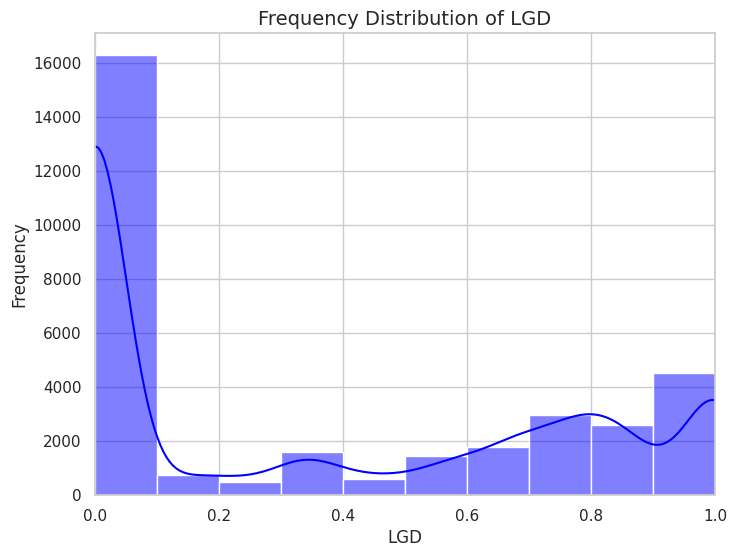

In [5]:
import seaborn as sns

# Set the style for seaborn plots
sns.set(style="whitegrid")

# Plot the frequency distribution (histogram) for the 'LGD' column
plt.figure(figsize=(8, 6))
sns.histplot(data['LGD'], bins=10, kde=True, color='blue')


# Set the x-axis range from -2 to 2
plt.xlim(0, 1)

# Add labels and title
plt.title('Frequency Distribution of LGD', fontsize=14)
plt.xlabel('LGD', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.show()